# Working with Raster Bands

## Preparing Your Workspace

### Option 1: (recommended) Run in Google Colab
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kevinlacaille/presentations/blob/main/scipy2024/5_segmentation.ipynb)

### Option 2: Run local Jupyter instance
You can also choose to open this Notebook in your own local Jupyter instance.

**Prerequisites**

- Install: rasterio
- Download data

In [11]:
!pip install rasterio
!wget https://raw.githubusercontent.com/kevinlacaille/presentations/main/scipy2024/data/presentation/8928dec4ddbffff/DJI_0876.JPG

Let's get the vegetation and non-vegetation masks as we did in `4_masks_and_filters.ipynb`.

In [12]:
import rasterio
import cv2 as cv
import numpy as np
import os

# Path to the image
image_path = "/content/DJI_0876.JPG" if os.path.exists(
    "/content/DJI_0876.JPG"
) else "data/presentation/8928dec4ddbffff/DJI_0876.JPG"

# Open the image and read the bands as numpy arrays
with rasterio.open(image_path) as src:
    blue = src.read(1)
    green = src.read(2)
    red = src.read(3)

# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Stack the bands to create a color image
rgb = np.dstack((blue, green, red))

# Get VARI index
vari = (green.astype(float) - red.astype(float)) / (
    green.astype(float) + red.astype(float) - blue.astype(float))

# Min and max values for the VARI index
vari_min = 0.1
vari_max = 0.5

# Generate the vegetation mask
vegetation_mask = np.full(vari.shape, np.nan)
vegetation_mask[(vari >= vari_min)] = 1

# Generate the non-vegetation mask
non_vegetation_mask = np.full(vari.shape, np.nan)
non_vegetation_mask[vari < vari_min] = 1

/Users/kevinlacaille/.pyenv/versions/3.11.4/envs/scipy2024-env/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Let's use the Ground Sampling Distance (GSD) we measured in `exif.ipynb` to convert real-world measurements to pixel dimensions for defining the morphological kernel size. The GSD represents the actual ground distance that each pixel covers, allowing us to translate real-world dimensions into the pixel space of the image.

We typically use a square kernel for morphological operations, so we take the square root of the pixel area to determine the side length of the kernel.

Ensure that the kernel size is odd to maintain symmetry around the central pixel during morphological operations.

In [13]:
# The ground sampling distance (GSD) of the image
gsd = 0.025  # meters per pixel

# Diameter of the tree in physical units
diameter_of_tree = 10  # meters

# Kernel size in pixels
kernel_size = int(np.sqrt(diameter_of_tree / gsd))  # square kernel size

# Ensure kernel size is odd
if kernel_size % 2 == 0:
    kernel_size += 1

print("Kernel size: ", kernel_size, "pixels")

Kernel size:  21 pixels


Apply the image processing pipeline we defined in the later half of `4_masks_and_filters.ipynb`.

In [14]:
# Apply a Gaussian blur to the vegetation mask
blur = cv.GaussianBlur(vegetation_mask, (7, 7), 0)

# Create the opening and closing kernels defined by the size of the tree
opening_kernel = np.ones((kernel_size, kernel_size), np.uint8)
closing_kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Apply morphological opening and closing to the blurred image
opening = cv.morphologyEx(blur, cv.MORPH_OPEN, opening_kernel)
closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, closing_kernel)

Create a purple mask overlay (combining red and blue channels) and apply it to the regions defined by the filtered mask. This will create an overlay for the filtered vegetation mask.

In [15]:
# Create a mask overlay with purple color (Red + Blue)
mask_overlay = np.zeros_like(rgb)
mask_overlay[:, :, 0] = 128  # Red channel for purple
mask_overlay[:, :, 1] = 0  # Green channel for purple
mask_overlay[:, :, 2] = 128  # Blue channel for purple

# Apply the filtered mask to the mask overlay
mask_overlay[closing != 1] = [0, 0, 0]  # Transparent where mask is not applied


Do the same as above, but for the non-vegetation mask.

In [16]:
# Create a non-vegetation mask by inverting the filtered vegetation mask
inverse_closing = np.logical_not(closing).astype(np.uint8)

# Create an inverse mask overlay with purple color
inverse_mask_overlay = np.zeros_like(rgb)
inverse_mask_overlay[:, :, 0] = 128  # Red channel for purple
inverse_mask_overlay[:, :, 1] = 0  # Green channel for purple
inverse_mask_overlay[:, :, 2] = 128  # Blue channel for purple

# Apply the inverse mask to the inverse mask overlay
inverse_mask_overlay[closing == 1] = [
    0, 0, 0
]  # Transparent where original mask is applied


Visualize the filtered vegetation and non-vegetation masks.

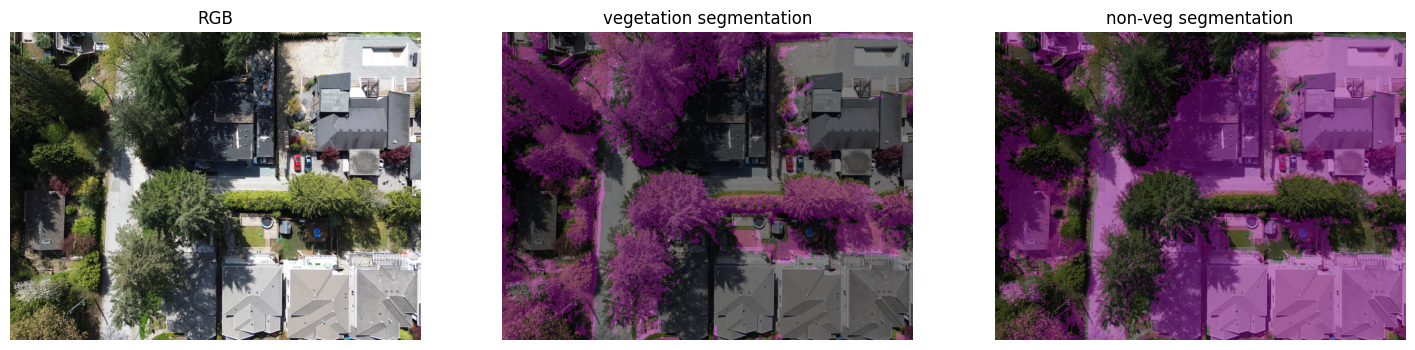

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

plt.sca(ax[0])
plt.imshow(rgb)
plt.axis('off')
plt.title('RGB')

plt.sca(ax[1])
plt.imshow(rgb)
plt.imshow(mask_overlay, alpha=0.5)
plt.axis('off')
plt.title('vegetation segmentation')

plt.sca(ax[2])
plt.imshow(rgb)
plt.imshow(inverse_mask_overlay, alpha=0.5)
plt.axis('off')
plt.title('non-veg segmentation')

plt.show()

This approach effectively segments vegetation in an image without using machine learning by leveraging remote sensing and image processing techniques!